Simulated features data

In [1]:
import numpy as np
import pandas as pd

# Simulate 1000 samples, 10 features, 10 categories
np.random.seed(42)
n_samples = 1000
n_features = 10
n_categories = 10

features = np.random.randn(n_samples, n_features) * 5 + 10
categories = np.repeat(np.arange(n_categories), n_samples // n_categories)
# Adjust for non-even division
categories = np.concatenate([categories, np.random.choice(np.arange(n_categories), n_samples - len(categories))])
np.random.shuffle(categories)

Features_df = pd.DataFrame(features, columns=[f'Feature_{i+1}' for i in range(n_features)])
Features_df['Categories'] = categories

Features_df.head()


,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Categories
0,12.483571,9.308678,13.238443,17.615149,8.829233,8.829315,17.896064,13.837174,7.652628,12.712800,7
1,7.682912,7.671351,11.209811,0.433599,1.375411,7.188562,4.935844,11.571237,5.459880,2.938481,1
2,17.328244,8.871118,10.337641,2.876259,7.278086,10.554613,4.245032,11.878490,6.996807,8.541531,2
3,6.991467,19.261391,9.932514,4.711445,14.112725,3.895782,11.044318,0.201649,3.359070,10.984306,4
4,13.692333,10.856841,9.421759,8.494482,2.607390,6.400779,7.696806,15.285611,11.718091,1.184799,5


## This module applies statistical tests to analyze the distributions of each feature within each category.
- The Shapiro-Wilk test checks if each feature's data (per category) is normally distributed.
 - The Kruskal-Wallis test compares medians across categories for each feature (non-parametric).

In [2]:
from scipy.stats import shapiro, kruskal

normality_pvals = []
for cat in range(n_categories):
    pvals_cat = []
    for feature in Features_df.columns[:-1]:
        data = Features_df.loc[Features_df['Categories'] == cat, feature]
        pvals_cat.append(shapiro(data)[1])
    normality_pvals.append(pvals_cat)

normality_df = pd.DataFrame(normality_pvals, columns=Features_df.columns[:-1])
display(normality_df.head())

kruskal_pvals = []
for feature in Features_df.columns[:-1]:
    groups = [Features_df[Features_df['Categories'] == c][feature].values for c in range(n_categories)]
    _, p = kruskal(*groups)
    kruskal_pvals.append(p)
kruskal_df = pd.DataFrame({'Feature': Features_df.columns[:-1], 'p-value': kruskal_pvals})
display(kruskal_df)


,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10
0,0.926379,0.758075,0.842399,0.904767,0.760451,0.810986,0.419236,0.342856,0.198891,0.036446
1,0.117153,0.218434,0.160637,0.951901,0.623732,0.495393,0.814065,0.626313,0.139140,0.358605
2,0.433223,0.002867,0.470144,0.132006,0.440095,0.268431,0.781843,0.590441,0.575743,0.937517
3,0.057862,0.765699,0.045238,0.766601,0.629315,0.260634,0.561248,0.783935,0.019697,0.184940
4,0.478365,0.794925,0.404786,0.880552,0.299479,0.473347,0.954207,0.837995,0.384829,0.765032


,Feature,p-value
0,Feature_1,0.002643
1,Feature_2,0.125033
2,Feature_3,0.597923
3,Feature_4,0.330041
4,Feature_5,0.749148
5,Feature_6,0.624843
6,Feature_7,0.938404
7,Feature_8,0.279471
8,Feature_9,0.427146
9,Feature_10,0.990716


## This module computes Fisher's Discriminant Ratio for each feature.
 The FDR quantifies how well each feature separates the categories.
 High FDR indicates good discrimination between classes.

In [3]:
# Group means
means_by_cat = Features_df.groupby('Categories').mean()
overall_mean = Features_df[Features_df.columns[:-1]].mean()

# Within-class scatter
within = np.zeros((n_features, n_features))
for cat in range(n_categories):
    Xc = Features_df.loc[Features_df['Categories'] == cat, Features_df.columns[:-1]].values
    mc = means_by_cat.loc[cat].values
    within += (Xc - mc).T @ (Xc - mc)
# Between-class scatter
between = np.zeros((n_features, n_features))
for cat in range(n_categories):
    n_c = sum(Features_df['Categories'] == cat)
    mc = means_by_cat.loc[cat].values
    between += n_c * np.outer(mc - overall_mean.values, mc - overall_mean.values)
# Fisher's ratio
fisher_ratio = np.diag(np.linalg.pinv(within) @ between)
fisher_df = pd.DataFrame({'Feature': Features_df.columns[:-1], 'FisherRatio': fisher_ratio})
display(fisher_df)


,Feature,FisherRatio
0,Feature_1,0.024330
1,Feature_2,0.013531
2,Feature_3,0.009360
3,Feature_4,0.008174
4,Feature_5,0.007412
5,Feature_6,0.008777
6,Feature_7,0.004919
7,Feature_8,0.012017
8,Feature_9,0.006615
9,Feature_10,0.002830


## This module calculates the Area Under the ROC Curve (AUC) for each feature and each category.
It quantifies how well each feature distinguishes one category from all others (one-vs-all approach).


In [4]:
from sklearn.metrics import roc_auc_score

auc_matrix = np.zeros((n_categories, n_features))
for i, cat in enumerate(range(n_categories)):
    for j, feat in enumerate(Features_df.columns[:-1]):
        y_true = (Features_df['Categories'] == cat).astype(int)
        auc = roc_auc_score(y_true, Features_df[feat])
        auc = max(auc, 1 - auc)  # Always >0.5
        auc_matrix[i, j] = auc
auc_df = pd.DataFrame(auc_matrix, columns=Features_df.columns[:-1])
display(auc_df.head())


,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10
0,0.550944,0.532411,0.526411,0.514789,0.537489,0.524656,0.501411,0.527278,0.537978,0.501044
1,0.594011,0.518756,0.530544,0.510278,0.505822,0.524233,0.527889,0.539956,0.546089,0.509033
2,0.500922,0.536111,0.542878,0.574067,0.508956,0.513656,0.518600,0.513622,0.541456,0.506411
3,0.502533,0.514833,0.517367,0.519811,0.546678,0.536800,0.525244,0.574489,0.523611,0.508544
4,0.548911,0.515889,0.523222,0.508033,0.511611,0.511400,0.502533,0.531722,0.507900,0.515522


## This module demonstrates a full machine learning classification workflow:
 - It splits the feature data into training and test sets.
 - Trains a Random Forest classifier on the training data.
 - Evaluates the classifier with metrics and a classification report on the test set.

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = Features_df[Features_df.columns[:-1]]
y = Features_df['Categories']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.04      0.04      0.04        25
           1       0.05      0.04      0.04        25
           2       0.08      0.12      0.09        25
           3       0.15      0.24      0.18        25
           4       0.15      0.12      0.13        25
           5       0.04      0.04      0.04        25
           6       0.00      0.00      0.00        25
           7       0.11      0.08      0.09        25
           8       0.00      0.00      0.00        25
           9       0.06      0.04      0.05        25

    accuracy                           0.07       250
   macro avg       0.07      0.07      0.07       250
weighted avg       0.07      0.07      0.07       250



## This module provides visualizations to understand the distribution and separation of features by category:
 - KDE plots show the estimated probability density of a feature for each category.
 - Boxplots visualize the distribution and spread of feature values per category.

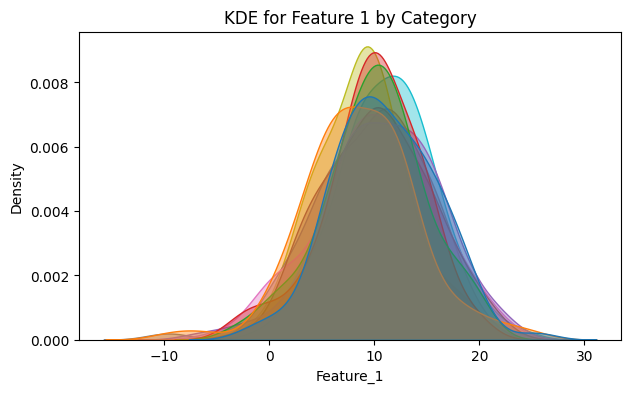

C:\Users\User\AppData\Local\Temp\ipykernel_25080\2539187509.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Categories', y='Feature_1', data=Features_df, palette='tab10')


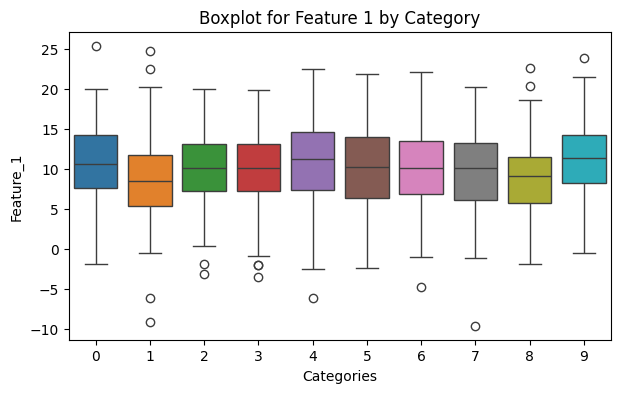

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# KDE for first feature
plt.figure(figsize=(7,4))
sns.kdeplot(data=Features_df, x='Feature_1', hue='Categories', fill=True, alpha=0.4, palette='tab10', legend=False)
plt.title('KDE for Feature 1 by Category')
plt.show()

# Boxplot for first feature
plt.figure(figsize=(7,4))
sns.boxplot(x='Categories', y='Feature_1', data=Features_df, palette='tab10')
plt.title('Boxplot for Feature 1 by Category')
plt.show()


- The above notebook simulates a typical statistical/ML workflow for features grouped by category:
    - **Feature extraction and group assignment**
    - **Normality and Kruskal-Wallis statistical tests**
    - **Fisher’s discriminant analysis**
    - **AUC-based feature evaluation**
    - **Random forest classifier training and report**
    - **Visual inspection via KDE and boxplots**
- You can replace the simulated data with your real data to use these exact algorithms.
